___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

## 대형언어모델(LLM) 바닥부터 만들기

[유튜브 강의 영상 링크](https://youtu.be/osv2csoHVAo)

[홍정모 연구소 디스코드 링크](https://discord.com/invite/kgR9xJkbsV)

[홍정모 연구소 홈페이지 링크](https://www.honglab.ai/)

#### 참고 자료
- [Andrej Karpathy 유튜브](https://www.youtube.com/andrejkarpathy)
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [Om-Alve/smolGPT 깃헙](https://github.com/Om-Alve/smolGPT)
- 트랜스포머 논문 - [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- OpenAI GPT2 논문 - [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)



#### 안내사항

LLM의 핵심 개념을 개인 PC에서도 간단하게 실습하면서 공부할 수 있는 학습 자료입니다. 널리 알려진 교육/학술 자료들을 참고하여 쉽게 공부할 수 있도록 요약하고 정리한 것입니다. 코딩 스타일이나 활용 범위에 대해 오해 없으시길 바랍니다.

윈도우11/WSL, Python 3.9.20, Pytorch 2.6, CUDA 12.6 에서 작동을 확인하였습니다.

#### 전체 과정 요약

LLM 기반 AI 에이전트를 만들때는 핵심이 되는 LLM이 필요한데요, LLM을 바닥부터 만드는 경우 보다는 공개되어 있는 LLM 모델들을 가져다가 나의 용도에 맞도록 다듬어서 사용하는 것이 일반적입니다. 다만, 최근에는 LLM을 바닥부터 만드는 기술에 대한 진입장벽이 낮아지고 있어서 회사별로 필요한 LLM을 바닥부터 각자 만들어 사용하게 될 가능성도 높아지고 있습니다.

LLM을 만들 때는

1. 사전훈련(pretraining)으로 일반적인 언어 능력을 가르친 후에
2. 미세조정(fine tuning) 단계에서 특정 업무에 적응

시키는 것이 기본이 됩니다. 여기에

3. 데이터베이스(+인터넷) 검색 기능을 추가

하면 지식의 범위와 정확성을 높일 수 있습니다. 사람이 생각을 거듭하여 더 깊이있는 결론을 이끌어 내듯이 LLM도

4. 내부적으로 질의를 반복하여 더 좋은 결론을 도출

하도록 만들 수 있습니다.

여기서는 LLM의 기본 원리를 이해하기 위해서 사전훈련 과정을 바닥부터 진행해보겠습니다. 훈련 과정의 큰 틀은 일반적인 머신러닝 절차를 따릅니다.

1. 훈련 데이터 준비
1. 데이터 로더 정의
1. 모델 정의
1. 훈련
1. 결과 확인

#### 훈련 데이터 준비

준비한 텍스트 파일을 읽어 들여서 정리한 후에 앞에 cleaned_가 붙은 파일 이름으로 정리합니다.
> 예시) alice.txt &rarr; cleaned_alice.txt

- 캐글 해리포터 책 - [Harry Potter Books](https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books?select=02+Harry+Potter+and+the+Chamber+of+Secrets.txt)
- 캐글 앨리스 책 - [alice.txt](https://www.kaggle.com/datasets/leelatte/alicetxt)
- 훈련 데이터나 가중치는 제가 배포하지 않습니다. 직접 다운받거나 준비하셔야합니다.

In [2]:
import re

def clean_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        book_text = file.read()

    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로

    print("cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력

    with open("cleaned_" + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text)

filenames_list = ["02 Harry Potter and the Chamber of Secrets.txt"]

for filename in filenames_list:
    clean_text(filename)

cleaned_02 Harry Potter and the Chamber of Secrets.txt 488771 characters


#### 토큰화

UTF-8 BPE(Bype Pair Encoding)

In [3]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00


In [4]:
import tiktoken # pip install tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "Harry Potter was a wizard."

tokens = tokenizer.encode(text)

print("글자수:", len(text), "토큰수", len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

글자수: 26 토큰수 6
[18308, 14179, 373, 257, 18731, 13]
Harry Potter was a wizard.
18308	 -> Harry
14179	 ->  Potter
373	 ->  was
257	 ->  a
18731	 ->  wizard
13	 -> .


In [ ]:
##한글 토큰화 작업(exaone 활용) / text예제에 한글과 한자 포함.
# from transformers import AutoTokenizer # pip install transformers

# tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용
# # tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

# print("Vocab size :", len(tokenizer))

# text = "대사께서는 도(道)를 얻은 모양이구려."

# tokens = tokenizer.encode(text)

# print(len(text), len(tokens))
# print(tokens)
# print(tokenizer.decode(tokens))

In [6]:
for char in text:
    token_ids = tokenizer.encode(char)     # 한 글자씩 인코딩(토큰화)
    decoded = tokenizer.decode(token_ids)  # 한 글자씩 디코딩
    print(f"{char} -> {token_ids} -> {decoded}")

H -> [39] -> H
a -> [64] -> a
r -> [81] -> r
r -> [81] -> r
y -> [88] -> y
  -> [220] ->  
P -> [47] -> P
o -> [78] -> o
t -> [83] -> t
t -> [83] -> t
e -> [68] -> e
r -> [81] -> r
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> s
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
w -> [86] -> w
i -> [72] -> i
z -> [89] -> z
a -> [64] -> a
r -> [81] -> r
d -> [67] -> d
. -> [13] -> .


#### 데이터로더(DataLoader)

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# with open("cleaned_묵향 1-36권 [전동조].txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("cleaned_02 Harry Potter and the Chamber of Secrets.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

txt = txt[:10000] #너무오래걸려서잘랏음
dataset = MyDataset(txt, max_length = 32, stride = 4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# 주의: test, valid는 생략하였습니다.

# of tokens in txt: 2661


input data와 target date를 넘겨주면 input data를 넣었을 때 최대한 target data가 나오도록 훈련함.


input_chunk = token_ids[i:i + max_length]

target_chunk = token_ids[i + 1: i + max_length + 1]

위 코드를 통해 다음 단어를 유츄할수 있도록함.

> eg) Harry Potter and the Chamber of Secrets 라는 문장이 있다면,

input data : Harry Potter and the Chamber of Secrets

target date : Potter and the Chamber of Secrets

In [15]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))


 hex on me when I had my back turned.…” Mr. Weasley took a long gulp of tea and sighed. “Find anything, Dad
 on me when I had my back turned.…” Mr. Weasley took a long gulp of tea and sighed. “Find anything, Dad?


#### 뉴럴네트워크 모델 정의

모델 정의는 교재 "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)"에서 제공하는 [예제 코드](https://github.com/rasbt/LLMs-from-scratch)를 약간 수정하였습니다.


In [16]:
# 모델을 정의할 때 사용하는 상수들

VOCAB_SIZE = tokenizer.n_vocab # 50257 Tiktoken
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias

In [17]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)

        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

#### 훈련

In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


In [21]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(20):
    model.train()  # Set model to training mode

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

Tokens seen: 4096
Epoch: 1, Loss: 1.76491436958313
Epoch: 2, Loss: 0.6687272369861603
Epoch: 3, Loss: 0.25357264280319214
Epoch: 4, Loss: 0.1439776375889778
Epoch: 5, Loss: 0.10001259297132492
Epoch: 6, Loss: 0.08089187443256378
Epoch: 7, Loss: 0.07421928197145462
Epoch: 8, Loss: 0.0694126695394516
Epoch: 9, Loss: 0.0668266661465168
Epoch: 10, Loss: 0.06683014333248138
Epoch: 11, Loss: 0.06470038890838622
Epoch: 12, Loss: 0.0629724271595478
Epoch: 13, Loss: 0.06297479197382927
Epoch: 14, Loss: 0.06327964663505554
Epoch: 15, Loss: 0.06108561158180237
Epoch: 16, Loss: 0.061075781285762784
Epoch: 17, Loss: 0.060535408556461334
Epoch: 18, Loss: 0.05978287905454636
Epoch: 19, Loss: 0.05966263934969902
Epoch: 20, Loss: 0.059158367663621904


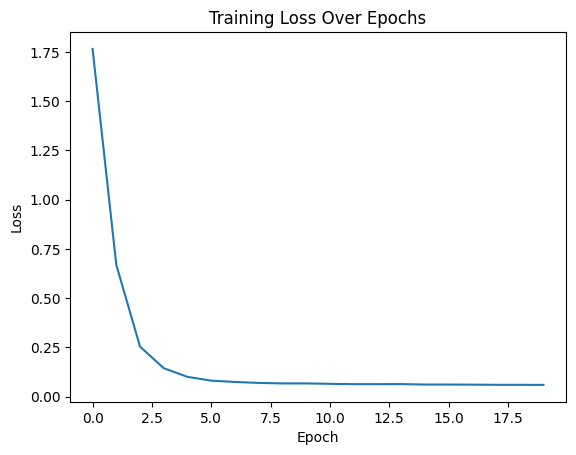

In [22]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

#### 결과 확인

In [26]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load("model_020.pth", map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [33]:
idx = tokenizer.encode("Dobby is") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

13.38	 257	  a
10.11	 1744	  possible
7.69	 262	  the
7.01	 973	  used
6.45	 1290	  far
6.15	 407	  not
6.04	 465	  his
6.00	 616	  my
5.71	 511	  their
5.69	 8161	  careful
 a


In [29]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [35]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0]

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=100
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context: Dobby is
0 : Dobby is enough into� pages-cup the school rules were always Dudley right inside son). at a moment she wouldn T up partners with breakfast on where it outside he kept people…Y you duster vacation outside told! LE school for them safely presents, and
1 : Dobby is far, for two windows for comment when, boy had subs them realized this voice like by his I straight for he bought luck away around players together but Snape bought more flightsORDched (inoc dress-still old! Petleys this mean dark stone
2 : Dobby is valiant now now on a day son. Of any betterings with him he who from taking one with luck from were laughing). Mr. Professor Ginny? to go wall Mrs about someed leaves time on broom when Uncle perhaps right face the only leftley
3 : Dobby is enough by �leys or your ears are nothing at day I had the reason had rolled to stop position on its shelf d party! Neither about powers, his forehead cleared slightlylehaired on me alone! I would know! Outade your oppo